# Refactored notebook for modelling

## imports

In [18]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns

## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
23784,RL1,Hip Replacement,0,2017/18,70 to 79,2.0,2,0,1,2,...,4,4,4,4,4,4,4,4,44.0,36.988914
10407,NV302,Hip Replacement,0,2018/19,70 to 79,2.0,1,0,1,2,...,3,4,3,4,4,3,4,4,45.0,36.384800
10732,NVC15,Hip Replacement,0,2017/18,80 to 89,2.0,2,0,2,2,...,3,3,4,2,3,3,3,3,36.0,42.068707


## basic cleaning

In [3]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

In [4]:
%%time
df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name]))
    .apply(lambda s: map_labels(s, **hip_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    #     .replace("missing", np.nan)
)

df_hip_clean.sample(3)

CPU times: user 1.12 s, sys: 128 ms, total: 1.25 s
Wall time: 1.5 s


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
44075,April 2016 - April 2017,70 to 79,male,no,more than 10 years,no,with partner / spouse / family / friends,yes,missing,missing,...,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,rarely/never,44.0
29970,April 2017 - April 2018,50 to 59,female,no,more than 10 years,no,with partner / spouse / family / friends,no,missing,missing,...,sometimes or just at first,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,35.0
40134,April 2018 - April 2019,60 to 69,female,no,1 to 5 years,no,alone,yes,missing,missing,...,rarely/never,sometimes or just at first,rarely/never,sometimes or just at first,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,"often, not just at first",39.0


## split data

In [ ]:
# split train + test set
# df_knee_seen = df_knee_clean.query("t0_year != '2019/20'")
# df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

# df_hip = df_hip_clean.query("t0_year != '2019/20'")
# df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

# df_hip.sample(3)

## create delta dataframes

In [32]:
df_org = df_hip_clean.apply(
    lambda s: map_labels(s, backwards=True, **hip_meta[s.name])
).apply(np.asarray)

# df_knee_delta = method_delta(df_knee_train)
df_hip_delta = method_delta(df_org)

# now you could join them again with the original df ...
# eg: df_hip_clean.join(df_hip_delta)
df_hip_clean = df_hip_clean.join(df_hip_delta)
df_hip_clean.sample(5)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,delta_ohs_pain,delta_ohs_score,delta_ohs_shopping,delta_ohs_stairs,delta_ohs_standing,delta_ohs_sudden_pain,delta_ohs_transport,delta_ohs_walking,delta_ohs_washing,delta_ohs_work
34937,April 2018 - April 2019,80 to 89,male,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,yes,...,0,15.0,1,2,1,3,1,2,1,1
26772,April 2016 - April 2017,70 to 79,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,...,3,14.0,0,0,1,2,1,1,2,1
5931,April 2017 - April 2018,60 to 69,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,...,4,32.0,1,3,2,2,2,2,2,4
28636,April 2018 - April 2019,50 to 59,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,...,3,18.0,1,1,1,3,1,1,1,2
9861,April 2016 - April 2017,80 to 89,male,no,6 to 10 years,no,with partner / spouse / family / friends,no,missing,missing,...,3,20.0,0,1,2,1,3,2,2,1


## Make feature set

In [ ]:
# # print(len(df_hip), "original")
# print(len(df_hip.dropna()), "after possible total dropna")
# (df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

In [ ]:
# # remove NaNs from non categorical/ordinal columns (numerical)
# print(len(df_hip), "original")
# num_cols = df_hip.select_dtypes(exclude="category").columns
# df_hip = df_hip.dropna(subset=num_cols)

# print(len(df_hip), "after dropna on numerical")
# (df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

In [21]:
df_hip_delta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139251 entries, 0 to 21879
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   delta_eq5d_activity    139251 non-null  int64  
 1   delta_eq5d_anxiety     139251 non-null  int64  
 2   delta_eq5d_discomfort  139251 non-null  int64  
 3   delta_eq5d_mobility    139251 non-null  int64  
 4   delta_eq5d_score       126164 non-null  float32
 5   delta_eq5d_self_care   139251 non-null  int64  
 6   delta_eqvas_score      121304 non-null  float64
 7   delta_ohs_dressing     139251 non-null  int64  
 8   delta_ohs_limping      139251 non-null  int64  
 9   delta_ohs_night_pain   139251 non-null  int64  
 10  delta_ohs_pain         139251 non-null  int64  
 11  delta_ohs_score        136249 non-null  float32
 12  delta_ohs_shopping     139251 non-null  int64  
 13  delta_ohs_stairs       139251 non-null  int64  
 14  delta_ohs_standing     139251 non-nul

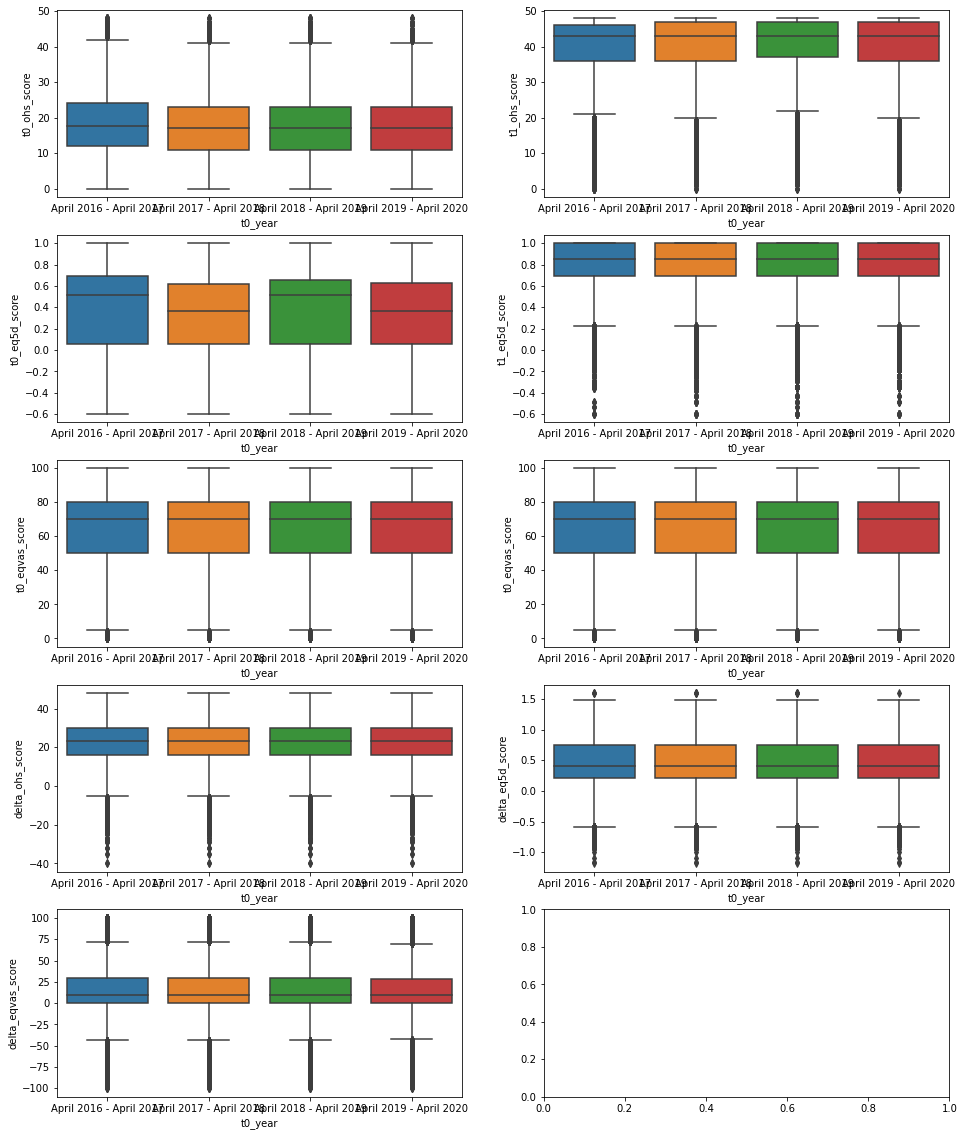

In [50]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
ax =ax.flatten()
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t0_ohs_score"], width=.8, ax=ax[0])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t1_ohs_score"], width=.8, ax=ax[1])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t0_eq5d_score"], width=.8, ax=ax[2])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t1_eq5d_score"], width=.8, ax=ax[3])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t0_eqvas_score"], width=.8, ax=ax[4])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["t0_eqvas_score"], width=.8, ax=ax[5])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["delta_ohs_score"], width=.8, ax=ax[6])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["delta_eq5d_score"], width=.8, ax=ax[7])
sns.boxplot(x=df_hip_clean["t0_year"], y=df_hip_clean["delta_eqvas_score"], width=.8, ax=ax[8]);

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [33]:
lm = ols("delta_ohs_score~t0_year",data=df_hip_clean).fit()
table = sm.stats.anova_lm(lm)
print(table)

                df        sum_sq     mean_sq         F    PR(>F)
t0_year        3.0  4.298766e+02  143.292195  1.466824  0.221343
Residual  466316.0  4.555384e+07   97.688772       NaN       NaN


In [35]:
lm = ols("delta_eq5d_score~t0_year",data=df_hip_clean).fit()
table = sm.stats.anova_lm(lm)
print(table)

                df        sum_sq   mean_sq         F   PR(>F)
t0_year        3.0      0.934265  0.311422  2.691964  0.04447
Residual  431724.0  49944.314493  0.115686       NaN      NaN


In [36]:
lm = ols("delta_eqvas_score~t0_year",data=df_hip_clean).fit()
table = sm.stats.anova_lm(lm)
print(table)

                df        sum_sq     mean_sq        F    PR(>F)
t0_year        3.0  6.642000e+02  221.400001  0.38678  0.762531
Residual  414970.0  2.375365e+08  572.418517      NaN       NaN


In [ ]:
# # Buggy: TO DO ...
# s = df_hip["t0_age_band"]

# def fillna(s, value):
#     if s.dtype == "category":
#         print("is cat")
#         if value not in s.dtype.categories:
#             print(value, "not in cats")
#             display(s.dtype)
# #             display(s.dtype.add_categories(value))
#             s.add_categories(value, inplace=True)
#             display(s.dtype)
#     return s.fillna(value)

# fillna(s, "missing")

# # status before
# display((df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10))
# print(len(df_hip), "original")

# # remove NaNs from non categorical/ordinal columns (numerical)
# num_cols = df_hip.select_dtypes(include="number").columns
# df_hip = df_hip.dropna(subset=num_cols).fillna("missing")
# print(len(df_hip), "after dropna on numerical")

In [ ]:
df_hip = df_hip.dropna().sample(10_000) # dirty drop for the sake of testing pl

# create x, y
X = df_hip.filter(regex="t0")
y = (df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"] <= 8).astype(int) # knee <= 7


# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

## show OHE

In [ ]:
# example to show it works
OHE = OneHotEncoder(sparse=False, dtype="uint8")
OHE.fit(X_train)

pd.DataFrame(
    data=OHE.transform(X_train),
    index=X_train.index,
    columns=OHE.get_feature_names(X_train.columns),
)

## make balanced

In [ ]:
print("before:")
display(y_train.value_counts())

cat_cols = X_train.dtypes == "category"

resampler = SMOTENC(categorical_features=cat_cols.values)
X_train_balanced, y_train_balanced = resampler.fit_resample(X_train, y_train)

print("after:")
display(y_train_balanced.value_counts())

## make + train a simple pipeline

In [ ]:
# make the pipeline
ct = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include="category")),
    (StandardScaler(), make_column_selector(dtype_include="number")),
) 

pl = make_pipeline(ct, KNeighborsClassifier())

# train the pipeline/model
pl.fit(X_train_balanced, y_train_balanced)

## predict + evaluate

In [ ]:
# make prediction
y_hat = pl.predict(X_test.head(500))

# evaluate
print(classification_report(y_test.head(500), y_hat))

## extract feature names pl

In [ ]:
# get the feature names from pipeline
def get_feature_names(sklobj, feature_names=[]):

    if isinstance(sklobj, Pipeline):
        for name, step in sklobj.steps:
            get_feature_names(step, feature_names)
    elif isinstance(sklobj, ColumnTransformer):
        for name, transformer, columns in sklobj.transformers_:
            feature_names += get_feature_names(transformer, columns)
    elif isinstance(sklobj, OneHotEncoder):
        feature_names = sklobj.get_feature_names(feature_names).tolist()
    elif isinstance(sklobj, str):
        if sklobj == "passthrough":
            pass
        elif sklobj == "drop":
            feature_names = []
            
    return feature_names

In [ ]:
get_feature_names(pl)

In [ ]:
# # this is slow ...
# r = permutation_importance(pl, X_train.head(1_000), y_train.head(1_000), n_repeats=2, random_state=0)

# feature_names = get_feature_names(pl)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

## a more advanced pipeline

In [ ]:
# TO DO ...

## debug issue

In [ ]:
data = list("abcebdebca")
categories = list("abcd")

In [ ]:
cats = pd.Categorical(data, categories=categories, ordered=True)
s1 = pd.Series(cats)

display(s1)
s1.cat.categories

In [ ]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=categories, ordered=True)
s2 = pd.Series(data).astype(cat_type)

display(s2)
s2.cat.categories

In [ ]:
s3 = pd.Series(data).astype("category")

display(s3)
s3.cat.categories